In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets
 
import torchvision
from torchvision import transforms
from torchvision import models
 
import torch.nn.functional as F
import torchvision.transforms.functional as TF
 
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time

from tqdm import tqdm # progress bar

import skimage
from skimage import img_as_ubyte, img_as_float32

from sklearn.model_selection import StratifiedShuffleSplit

from glob import glob

from torchsummary import summary

import math
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
#########################################
# Parameters 
#########################################

viz_image_paths = glob('/Users/racoon/Downloads/open-images-sample/*.jpg')
training_image_paths = glob('/data/open-images-dataset/train/*.jpg')
validation_image_paths = glob('/data/open-images-dataset/validation/*.jpg')

train_dataset_length = 40192 # 314 iterations
validation_dataset_length = 2048 
train_batch_size = 128
validation_batch_size = 128
num_epochs = 1500
save_after_epochs = 1 
model_save_prefix = "shuffle_patch_r"

patch_dim = 96
gap = 32
jitter = 16
gray_portion = .30

learn_rate = 0.0001
momentum = 0.974
weight_decay = 0.0005

In [5]:

#########################################
# Utilities 
#########################################

def imshow(img,text=None,should_save=False):
    plt.figure(figsize=(10, 10))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  

def show_plot(iteration,loss,fname):
    plt.plot(iteration,loss)
    plt.savefig(fname)
    plt.show()
    
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for i, t in enumerate(tensor):
            t.mul_(self.std[i%3]).add_(self.mean[i%3])
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))



In [6]:
#########################################
# This class generates patches for training
#########################################

patch_order_arr = [
  (0, 1, 2, 3),
  (0, 1, 3, 2),
  (0, 2, 1, 3),
  (0, 2, 3, 1),
  (0, 3, 1, 2),
  (0, 3, 2, 1),
  (1, 0, 2, 3),
  (1, 0, 3, 2),
  (1, 2, 0, 3),
  (1, 2, 3, 0),
  (1, 3, 0, 2),
  (1, 3, 2, 0),
  (2, 0, 1, 3),
  (2, 0, 3, 1),
  (2, 1, 0, 3),
  (2, 1, 3, 0),
  (2, 3, 0, 1),
  (2, 3, 1, 0),
  (3, 0, 1, 2),
  (3, 0, 2, 1),
  (3, 1, 0, 2),
  (3, 1, 2, 0),
  (3, 2, 0, 1),
  (3, 2, 1, 0)
]

class ShufflePatchDataset(Dataset):

  def __init__(self, image_paths, patch_dim, length, gap, jitter, transform=None):
    self.image_paths = image_paths
    self.patch_dim = patch_dim
    self.length = length
    self.gap = gap
    self.jitter = jitter
    self.transform = transform
    self.color_shift = 2
    self.margin = math.ceil((2*patch_dim + 2*jitter + 2*self.color_shift + gap)/2)
    self.min_width = 2 * self.margin + 1

  def __len__(self):
    return self.length
  
  def half_gap(self):
    return math.ceil(self.gap/2)

  def random_jitter(self):
    return int(math.floor((self.jitter * 2 * random.random()))) - self.jitter

  def random_shift(self):
    return random.randrange(self.color_shift * 2 + 1)

  # crops the patch by self.color_shift on each side
  def prep_patch(self, image, gray):
 
    cropped = np.empty((self.patch_dim, self.patch_dim, 3), dtype=np.uint8)

    if(gray):

      pil_patch = Image.fromarray(image)
      pil_patch = pil_patch.convert('L')
      pil_patch = pil_patch.convert('RGB')
      np.copyto(cropped, np.array(pil_patch)[self.color_shift:self.color_shift+self.patch_dim, self.color_shift:self.color_shift+self.patch_dim, :])
      
    else:

      shift = [self.random_shift() for _ in range(6)]
      cropped[:,:,0] = image[shift[0]:shift[0]+self.patch_dim, shift[1]:shift[1]+self.patch_dim, 0]
      cropped[:,:,1] = image[shift[2]:shift[2]+self.patch_dim, shift[3]:shift[3]+self.patch_dim, 1]
      cropped[:,:,2] = image[shift[4]:shift[4]+self.patch_dim, shift[5]:shift[5]+self.patch_dim, 2]

    return cropped


  def __getitem__(self, index):
    # [y, x, chan], dtype=uint8, top_left is (0,0)
        
    image_index = int(math.floor((len(self.image_paths) * random.random())))
    
    pil_image = Image.open(self.image_paths[image_index]).convert('RGB')

    image = np.array(pil_image)

    # If image is too small, try another image
    if (image.shape[0] - self.min_width) <= 0 or (image.shape[1] - self.min_width) <= 0:
        return self.__getitem__(index)
    
    center_y_coord = int(math.floor((image.shape[0] - self.margin*2) * random.random())) + self.margin
    center_x_coord = int(math.floor((image.shape[1] - self.margin*2) * random.random())) + self.margin

    patch_coords = [
      (
        center_y_coord - (self.patch_dim + self.half_gap() + self.random_jitter() + self.color_shift),
        center_x_coord - (self.patch_dim + self.half_gap() + self.random_jitter() + self.color_shift)
      ),
      (
        center_y_coord - (self.patch_dim + self.half_gap() + self.random_jitter() + self.color_shift),
        center_x_coord + self.half_gap() + self.random_jitter() - self.color_shift
      ),
      (
        center_y_coord + self.half_gap() + self.random_jitter() - self.color_shift,
        center_x_coord - (self.patch_dim + self.half_gap() + self.random_jitter() + self.color_shift)
      ),
      (
        center_y_coord + self.half_gap() + self.random_jitter() - self.color_shift,
        center_x_coord + self.half_gap() + self.random_jitter() - self.color_shift
      )
    ]
    
    patch_shuffle_order_label = int(math.floor((24 * random.random())))

    patch_coords = [pc for _,pc in sorted(zip(patch_order_arr[patch_shuffle_order_label],patch_coords))]

    patch_a = image[patch_coords[0][0]:patch_coords[0][0]+self.patch_dim+2*self.color_shift, patch_coords[0][1]:patch_coords[0][1]+self.patch_dim+2*self.color_shift]
    patch_b = image[patch_coords[1][0]:patch_coords[1][0]+self.patch_dim+2*self.color_shift, patch_coords[1][1]:patch_coords[1][1]+self.patch_dim+2*self.color_shift]
    patch_c = image[patch_coords[2][0]:patch_coords[2][0]+self.patch_dim+2*self.color_shift, patch_coords[2][1]:patch_coords[2][1]+self.patch_dim+2*self.color_shift]
    patch_d = image[patch_coords[3][0]:patch_coords[3][0]+self.patch_dim+2*self.color_shift, patch_coords[3][1]:patch_coords[3][1]+self.patch_dim+2*self.color_shift]

    gray = random.random() < gray_portion

    patch_a = patch_a[self.color_shift:self.color_shift+self.patch_dim, self.color_shift:self.color_shift+self.patch_dim, :]
    patch_b = patch_b[self.color_shift:self.color_shift+self.patch_dim, self.color_shift:self.color_shift+self.patch_dim, :]
    patch_c = patch_c[self.color_shift:self.color_shift+self.patch_dim, self.color_shift:self.color_shift+self.patch_dim, :]
    patch_d = patch_d[self.color_shift:self.color_shift+self.patch_dim, self.color_shift:self.color_shift+self.patch_dim, :]

    patch_shuffle_order_label = np.array(patch_shuffle_order_label).astype(np.int64)
        
    if self.transform:
      patch_a = self.transform(patch_a)
      patch_b = self.transform(patch_b)
      patch_c = self.transform(patch_c)
      patch_d = self.transform(patch_d)

    return patch_a, patch_b, patch_c, patch_d, patch_shuffle_order_label

In [7]:

##################################################
# Creating Train/Validation dataset and dataloader
##################################################

traindataset = ShufflePatchDataset(training_image_paths, patch_dim, train_dataset_length, gap, jitter,
                         transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

trainloader = torch.utils.data.DataLoader(traindataset, 
                                          batch_size=train_batch_size,
                                          num_workers=4,
                                          shuffle=False)


valdataset = ShufflePatchDataset(validation_image_paths, patch_dim, validation_dataset_length, gap, jitter,
                         transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=validation_batch_size,
                                        num_workers=4,
                                        shuffle=False)


valdataset = ShufflePatchDataset(viz_image_paths, patch_dim, 1, gap, jitter,
                         transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=1,
                                        shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


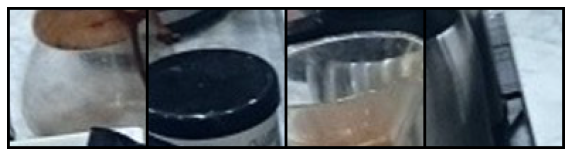

Labels: [16]


In [45]:
#############################
# Visualizing validation dataset
#############################

example_batch_val = next(iter(valloader))
concatenated = torch.cat((unorm(example_batch_val[0]),unorm(example_batch_val[1]),unorm(example_batch_val[2]),unorm(example_batch_val[3])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch_val[4].numpy()}')
